## Quick Start

To get started with *pymgrid*, first [clone or install](../../html/getting_started.html) the package.

This notebook shows how to define a simple microgrid, create actions to control it, and read the results. Microgrids can be defined by either defining a set of modules and then passing them to the ``Microgrid`` constructor or by a YAML config file. We detail the first case here.

In [69]:
import numpy as np
import pandas as pd

np.random.seed(0)

from pymgrid import Microgrid
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule)

### Defining a Microgrid

We can then define some components of our microgrid. We will define two batteries, one with a capacity of 100 kWh and another with a slower charging rate and lower efficiency but a capacity of 1000 kWh.

In [72]:
small_battery = BatteryModule(min_capacity=10,
                              max_capacity=100,
                              max_charge=50,
                              max_discharge=50,
                              efficiency=0.9,
                              init_soc=0.2)

large_battery = BatteryModule(min_capacity=10,
                              max_capacity=1000,
                              max_charge=10,
                              max_discharge=10,
                              efficiency=0.7,
                              init_soc=0.2)

We will also define a load and photovoltaic (pv) module -- the latter representing, say, a solar farm -- with some random data. We will define 90 days worth of data, in hourly increments.

In [74]:
load_ts = 100+100*np.random.rand(24*90) # random load data in the range [100, 200].
pv_ts = 200*np.random.rand(24*90) # random pv data in the range [0, 200].

load = LoadModule(time_series=load_ts)

pv = RenewableModule(time_series=pv_ts)

Finally, we define an external electrical grid to fill any energy gaps. 

The grid time series must contain three or four columns. The first three denote import price, export price, and carbon dioxide production per kWh. If a fourth column exists, it denotes the grid status (as a bool); if it does not, the grid is assumed to always be up and running.

In [76]:
grid_ts = [0.2, 0.1, 0.5] * np.ones((24*90, 3))

grid = GridModule(max_import=100,
                  max_export=100,
                  time_series=grid_ts)

We can then pass these to the ``Microgrid`` constructor to define a microgrid. Here, we give our renewable module the name "pv".

In [78]:
modules = [
    small_battery, 
    large_battery,
    ('pv', pv),
    load,
    grid]

microgrid = Microgrid(modules)

Printing the microgrid will tell us the modules contained in that microgrid. By default a ``balancing`` module is added to keep track of any unmet demand or excess production. This can be disabled by passing ``unbalanced_energy_module=False``, but is not recommended.

In [80]:
print(microgrid)

Microgrid([load x 1, pv x 1, balancing x 1, battery x 2, grid x 1])


We can then access the modules in the microgrid by name or by key:

In [82]:
print(microgrid.modules.pv)

[RenewableModule(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, provided_energy_name=renewable_used)]


In [83]:
print(microgrid.modules.grid is microgrid.modules['grid'])

True


### Controlling a microgrid

You must pass an action for each ``controllable`` module to control the microgrid. The fixed modules are stored in the attribute ``microgrid.controllable``:

In [85]:
microgrid.controllable

{
  "battery": "[BatteryModule(min_capacity=10, max_capacity=100, max_charge=50, max_discharge=50, efficiency=0.9, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False), BatteryModule(min_capacity=10, max_capacity=1000, max_charge=10, max_discharge=10, efficiency=0.7, battery_cost_cycle=0.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False)]",
  "grid": "[GridModule(max_import=100, max_export=100)]"
}

As we can see, our "load", "battery", and "grid" modules are fixed.

We can also view what modules we need to pass an action for by getting an empty action from the microgrid. Here, all ``None`` values must be replaced to pass this action as a control.

In [87]:
print(microgrid.get_empty_action())

{'battery': [None, None], 'grid': [None]}


We can then simply define a control for these modules. Before doing so, we will reset our microgrid and then check its current state.

In [89]:
microgrid.reset()
microgrid.state_series.to_frame()

0
load    0 load_current         -171.518937
pv      0 renewable_current     145.789539
battery 0 soc                     0.200000
          current_charge         20.000000
        1 soc                     0.200000
          current_charge        200.000000
grid    0 import_price_current    0.200000
          export_price_current    0.100000
          co2_per_kwh_current     0.500000
          grid_status_current     1.000000

We will attempt to meet our load demand of 169.646919 by using our available renewable and then discharging our batteries:

In [91]:
load = -1.0 * microgrid.modules.load.item().current_load
pv = microgrid.modules.pv.item().current_renewable

In [92]:
net_load = load + pv # negative if load demand exceeds pv

if net_load > 0:
    net_load = 0.0

For our batteries, we will attempt to generate the lower of the excess load and the maximum production.

In [94]:
battery_0_discharge = min(-1*net_load, microgrid.modules.battery[0].max_production)
net_load += battery_0_discharge

battery_1_discharge = min(-1*net_load, microgrid.modules.battery[1].max_production)
net_load += battery_1_discharge

Finally, we will let our grid clean up the rest -- or as must as it can.

In [96]:
grid_import = min(-1*net_load, microgrid.modules.grid.item().max_production)

Putting this together, we have our control. 

**Note that positive values denote energy moving into the microgrid and negative values denote energy leaving the microgrid.**

In [98]:
control = {"battery" : [battery_0_discharge, battery_1_discharge],
           "grid": [grid_import]}

control

{'battery': [9.0, 7.0], 'grid': [9.729397408557361]}

We can then run the microgrid with this control. Since this control is not normalized, we pass ``normalized=False``.

In [100]:
obs, reward, done, info = microgrid.run(control, normalized=False)

### Analyzing Results

After passing a control to the microgrid, we can view the results by viewing the microgrid's -- or any of the modules -- logs. 

The microgrid's log has one row for each action taken. There are values for both the actions -- e.g. the amount of load met -- as well as the state: for example, the current load. 

**Note that the state values are the values of the state from *before* the action was taken.**

The columns are a ``pd.MultiIndex``, with three levels: module names, module name enumeration (e.g. which number of each module name we are in) and property.

For example, since there is one ``load``, all of its log entries will be available under the key ``('load', 0)``. Since there are two batteries, there will be both ``(battery, 0)`` and ``(battery, 1)``.

We can see that we met all of our load:

In [103]:
microgrid.log.loc[:, pd.IndexSlice['load', 0, :]]

module_name     load                         
module_number      0                         
field         reward    load_met load_current
0                0.0  171.518937  -171.518937

And consumed all available pv, even though we did not define a control for it:

In [105]:
microgrid.log.loc[:, pd.IndexSlice['pv', 0, :]]

module_name       pv                                             
module_number      0                                             
field         reward curtailment renewable_used renewable_current
0                0.0         0.0     145.789539        145.789539

Since we have two batteries, we will have log entries for each of them:

In [107]:
microgrid.log.loc[:, 'battery']

module_number      0                                                     \
field         reward discharge_amount charge_amount  soc current_charge   
0               -0.0              9.0           0.0  0.2           20.0   

module_number      1                                                     
field         reward discharge_amount charge_amount  soc current_charge  
0               -0.0              7.0           0.0  0.2          200.0

### Plotting Results

We can also utilize pandas plotting functionality to view results. To illustrate this, we will run the microgrid for an additional ten steps with randomly sampled actions.

In [109]:
for _ in range(10):
    microgrid.run(microgrid.sample_action(strict_bound=True))

Here we will plot the load met, pv consumed and loss load:

<Axes: >

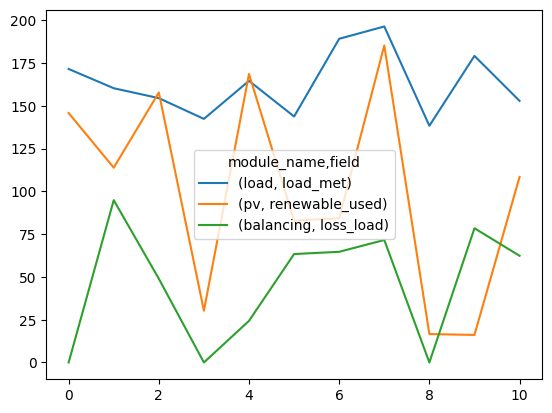

In [111]:
microgrid.log[[('load', 0, 'load_met'), 
               ('pv', 0, 'renewable_used'),
               ('balancing', 0, 'loss_load')]].droplevel(axis=1, level=1).plot()

In [135]:
df = microgrid.get_log()

In [139]:
df['battery']

module_number      0                                                          \
field         reward discharge_amount charge_amount       soc current_charge   
0               -0.0         9.000000      0.000000  0.200000      20.000000   
1               -0.0         0.000000     25.255544  0.100000      10.000000   
2               -0.0         0.000000     31.100463  0.327300      32.729989   
3               -0.0        36.268150      0.000000  0.607204      60.720406   
4               -0.0         0.000000     17.030030  0.204225      20.422462   
5               -0.0         0.000000     34.462331  0.357495      35.749488   
6               -0.0         0.000000     31.787304  0.667656      66.765586   
7               -0.0        15.308551      0.000000  0.953742      95.374160   
8               -0.0        35.812021      0.000000  0.783647      78.364659   
9               -0.0         0.000000     11.886536  0.385735      38.573524   
10              -0.0        10.741957      0.000000  0.492714      49.271407   

module_number      1                                                          
field         reward discharge_amount charge_amount       soc current_charge  
0               -0.0         7.000000      0.000000  0.200000     200.000000  
1               -0.0         0.000000     12.547283  0.190000     190.000000  
2               -0.0         2.541352      0.000000  0.198783     198.783098  
3               -0.0         0.000000     10.251424  0.195153     195.152595  
4               -0.0         0.000000     11.726286  0.202329     202.328591  
5               -0.0         1.658063      0.000000  0.210537     210.536991  
6               -0.0         0.000000      5.397945  0.208168     208.168331  
7               -0.0         1.542993      0.000000  0.211947     211.946892  
8               -0.0         0.000000      3.591095  0.209743     209.742616  
9               -0.0         2.087804      0.000000  0.212256     212.256382  
10              -0.0         0.000000      1.998039  0.209274     209.273805